# Forecasting gold (Au) concentration

Knowing the amount of gold (Au) concentrate resulting from an ore mixture, or rougher feed, is not straight forward. Differing variables associated with each mixture make it difficult to predict how much gold concentrate there actually is. Some of these differing variables include the different concentrations of other elements within the feed, the different solutions that are used during the cleaning process, and the size of each feed can also be different. The overall makeup of the mixture containing the solid particles and liquid solutions is variant. In other words, there is no one size fits all. One mixture is more than likely completely different than the next.

<b>Zyfra</b> wants to be able to forecast the amount of gold concentrate that results from a rougher feed before it is extracted and purified. With the characteristics of many ore mixtures that have been processed throughout time, a machine learning model can help bridge this forecasting gap and will help optimize the production of gold in the future.

## Initialization

In [1]:
# Load libraries and modules
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.dummy import DummyRegressor
from sklearn.metrics import make_scorer 

## Load data

In [2]:
# Load data into pandas DataFrames
train_url = 'https://raw.githubusercontent.com/rmodesitt/data-projects-TripleTen/refs/heads/main/gold-mine-recovery/gold_recovery_train.csv'
test_url = 'https://raw.githubusercontent.com/rmodesitt/data-projects-TripleTen/refs/heads/main/gold-mine-recovery/gold_recovery_test.csv'
full_url = 'https://media.githubusercontent.com/media/rmodesitt/data-projects-TripleTen/refs/heads/main/gold-mine-recovery/gold_recovery_full.csv'
gold_train = pd.read_csv(train_url)
gold_test = pd.read_csv(test_url)
gold_full = pd.read_csv(full_url)

## Data overview

There were 3 datasets provided by Zyfra for analysis and machine learning: <b>gold_train</b>, <b>gold_test</b>, and <b>gold_full</b>. The first dataset is the training dataset, the second is the test dataset, and the third is a combination of the training and test datasets.

In both datasets, there is a <b><mark>date</mark></b> field that is an object data type, and all other fields are of a float data type. These other fields represent the different characteristics of the ore mixture and processes that were performed on it. In addition, the field names for each field (other than <b><mark>date</mark></b>) denote the stage of the ore process and the characteristics of the mixture at that stage. Here is how the fields / features are named in more detail.

- [<b>stage</b>].[<b>parameter_type</b>].[<b>parameter_name</b>] >>> rougher.input.feed_ag

Possible values for [<b>stage</b>].

- _rougher_ - flotation
- _primary cleaner_ - primary purification
- _secondary cleaner_ - secondary purification
- _final_ - final characteristics

Possible values for [<b>parameter_type</b>].

- _input_ - raw material parameters
- _output_ - product parameters
- _state_ - parameters characterizing the current state of the stage
- _calculation_ - calculation characteristics

In [3]:
print('Length of train and test datasets:', len(gold_train) + len(gold_test))
print('Length of full dataset:', len(gold_full))

Length of train and test datasets: 22716
Length of full dataset: 22716


In [4]:
gold_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [5]:
gold_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

### Training vs test dataset comparison - Missing parameters

After viewing the data of both datasets, there are clear differences in the number of records and columns. The number of records makes intuitive sense, because there needs to be ample data to be able to train the model effectively before it is tested. As for the difference in columns, there are <b>87</b> columns in the training dataset and <b>53</b> for the test dataset. The columns that are not in the test dataset are fields representing <b>outputs</b> and <b>calculations</b>. These parameter types represent the _results_ and _outcomes_ of ore processing. Furthermore, data that involves the results after a particular stage of the ore purification process, such as the resulting concentration of an element or concentration of a rougher tail, these data is not in the test dataset. Refer below for the specific fields.

In [6]:
# Count the number of columns in each stage of ore processing

# TRAINING
# Define variables and set counters
date = 0
rougher = 0
primary_cleaner = 0
secondary_cleaner = 0
final = 0

# Create loop that counts the number of columns
for i in gold_train.columns.tolist():
    if 'date' == i:
        date += 1
    elif 'rougher' in i:
        rougher += 1
    elif 'primary' in i:
        primary_cleaner += 1
    elif 'secondary' in i:
        secondary_cleaner += 1
    elif 'final' in i:
        final += 1
        
# Display results
print('\033[4mTraining\033[0m')
print('Total columns:', len(gold_train.columns.tolist()))
print('Date:', date)
print('Rougher:', rougher)
print('Primary cleaner:', primary_cleaner)
print('Secondary cleaner:', secondary_cleaner)
print('Final:', final)
print('\n')


# TEST
# Define variables and set counters
date = 0
rougher = 0
primary_cleaner = 0
secondary_cleaner = 0
final = 0

# Create loop that counts the number of columns
for i in gold_test.columns.tolist():
    if 'date' == i:
        date += 1
    elif 'rougher' in i:
        rougher += 1
    elif 'primary' in i:
        primary_cleaner += 1
    elif 'secondary' in i:
        secondary_cleaner += 1
    elif 'final' in i:
        final += 1
        
# Display results
print('\033[4mTest\033[0m')
print('Total columns:', len(gold_test.columns.tolist()))
print('Date:', date)
print('Rougher:', rougher)
print('Primary cleaner:', primary_cleaner)
print('Secondary cleaner:', secondary_cleaner)
print('Final:', final)

Training
Total columns: 87
Date: 1
Rougher: 35
Primary cleaner: 20
Secondary cleaner: 22
Final: 9


Test
Total columns: 53
Date: 1
Rougher: 22
Primary cleaner: 12
Secondary cleaner: 18
Final: 0


In [7]:
# Identify missing fields in the test dataset
pd.set_option('display.max_rows', None) 
missing_parameters = []
for i in gold_train.columns.tolist():
    if i not in gold_test.columns.tolist():
        missing_parameters.append(i)
print('Number of missing parameters in the test dataset:', len(missing_parameters))
display(missing_parameters)

# list(set(gold_train.columns.tolist()) - set(gold_test.columns.tolist()))

Number of missing parameters in the test dataset: 34


['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

### Recovery calculation validation

It is important that the recovery calculation in the training dataset is calculated correctly because that is what the model is trying to predict. If the values are incorrect before the model is trained, the model would be using inaccurate data to make predictions, thus resulting in a poor and misleading model. Fortunately, the mean absolute error (MAE) between the recovery values in the training dataset and recovery values that were calculated using a <b>recovery_calculate</b> function was <b>0.0</b>. Therefore, the recovery values in the dataset are correct and there is no need to replace any values or perform any data manipulation.

In [8]:
# Calculate rougher.output.recovery in training dataset
''' 
Recovery calculation (after floatation)

Recovery = C * (F - T) / F * (C - T)

C = Share of gold after floatation
F = Share of golf before floatation
T = Share of tails after floatation

-------------------------------------

Recovery = rougher.output.recovery
Recovery validate = rougher.output.recovery.validate

C = rougher.output.concentrate_au
F = rougher.input.feed_au
T = rougher.output.tail_au
'''

# Create a function that calculates the recovery
def recovery_calculate(df, output_gold, input_gold, tails):
    for index, row in df.iterrows():
        df['rougher.output.recovery.validate'] = ((output_gold * (input_gold - tails)) / (input_gold * (output_gold - tails))) * 100

# Update # of rows displayed
pd.set_option('display.max_rows', 10)

# Create a copy of the DataFrame
gold_train_test = gold_train.copy()

# Use the function to calculate the recovery
recovery_calculate(gold_train_test, gold_train_test['rougher.output.concentrate_au'], gold_train_test['rougher.input.feed_au'], gold_train_test['rougher.output.tail_au'])
display(gold_train_test[['rougher.output.recovery', 'rougher.output.recovery.validate']])

,rougher.output.recovery,rougher.output.recovery.validate
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794
...,...,...
16855,89.574376,89.574376
16856,87.724007,87.724007
16857,88.890579,88.890579
16858,89.858126,89.858126


In [9]:
# Calculate the MAE between rougher.output.recovery and rougher.output.recovery.validate
# Create a variable that ignores missing values
ignore_nan = ~np.isnan(gold_train_test['rougher.output.recovery'])

# Calculate the MAE
MAE = mean_absolute_error(gold_train_test['rougher.output.recovery'][ignore_nan], gold_train_test['rougher.output.recovery.validate'][ignore_nan])
print()
print(f"Mean absolute error: {MAE:.2f}")


Mean absolute error: 0.00


## Data preprocessing

### Duplicate values

There are no duplicate rows, nor any duplicate dates in either dataset. So, no cleanup is needed regarding duplicate data.

In [10]:
# Find duplicate rows
display(gold_train.duplicated().sum())
display(gold_test.duplicated().sum())

0

0

In [11]:
# Find duplicate dates
display(gold_train.duplicated(subset='date').sum())
display(gold_test.duplicated(subset='date').sum())

0

0

### Missing values

The data for both datasets are considered <b>time series</b>. A time series is a sequence of data points collected at successive, evenly spaced time intervals. There is a progression over time. This being the case, there are different best practice techniques that are encouraged on handling missing values.

There are several missing values in almost all columns for both training and test datasets. These "gaps" in the data are more than likely instrumentation failures or errors. Since there is a time progression in the data (ie the <b><mark>date</mark></b> field) and constant trends in the data over time, missing values were replaced with the <b>last known value</b>. This not only prevents the removal of important data, but the replacement value should be pretty representative of the actual value since the time increments were recorded every hour.

In [12]:
# Find missing values for the training dataset
display(gold_train.isna().sum())

date                                            0
final.output.concentrate_ag                    72
final.output.concentrate_pb                    72
final.output.concentrate_sol                  370
final.output.concentrate_au                    71
                                             ... 
secondary_cleaner.state.floatbank5_a_level     85
secondary_cleaner.state.floatbank5_b_air       85
secondary_cleaner.state.floatbank5_b_level     84
secondary_cleaner.state.floatbank6_a_air      103
secondary_cleaner.state.floatbank6_a_level     85
Length: 87, dtype: int64

In [13]:
# Find missing values for the test dataset
display(gold_test.isna().sum())

date                                            0
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
                                             ... 
secondary_cleaner.state.floatbank5_a_level     16
secondary_cleaner.state.floatbank5_b_air       16
secondary_cleaner.state.floatbank5_b_level     16
secondary_cleaner.state.floatbank6_a_air       16
secondary_cleaner.state.floatbank6_a_level     16
Length: 53, dtype: int64

In [14]:
# Fill missing values with previous known value using 'ffill'
gold_train = gold_train.fillna(method='ffill')
gold_test = gold_test.fillna(method='ffill')
print()
print('TRAINING')
display(gold_train.isna().sum())
print('TEST')
display(gold_test.isna().sum())


TRAINING


date                                          0
final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 87, dtype: int64

TEST


date                                          0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 53, dtype: int64

## Data analysis

### Concentration of metals by stage (Ag, Pb, Au)

#### Overview

How do the concentrations of the metals in the ore mixture change throughout the refining and purification process? An initial look at a handful of records below show a steady decrease in the concentrations of Ag, Pb, and Sol metals (in large part), and a steady increase of Au. This makes sense. As the ore mixture is refined and cleansed, more gold concentrate should result if the process is working effectively. More of the other metals are being cleansed out, leaving more % of gold concentrate left over. This is only a small sample size. Let's take a deeper dive into the distributions for each element. 

In [15]:
# Rougher input concentrations for Ag, Pb, Sol, and Au
rougher_concentrate = gold_train[['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol', 'rougher.input.feed_au']]
display(rougher_concentrate.head())

# Primary cleaner output concentrations for Ag, Pb, Sol, and Au
primary_concentrate = gold_train[['primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_au']]
display(primary_concentrate.head())

# Final output concentrations for Ag, Pb, Sol, and Au
final_concentrate = gold_train[['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au']]
display(final_concentrate.head())

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_au
0,6.100378,2.284912,36.808594,6.486150
1,6.161113,2.266033,35.753385,6.478583
2,6.116455,2.159622,35.971630,6.362222
3,6.043309,2.037807,36.862241,6.118189
4,6.060915,1.786875,34.347666,5.663707


,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au
0,8.547551,10.389648,19.529297,34.174427
1,8.558743,10.497069,19.369147,34.118526
2,8.603505,10.354494,19.167579,33.969464
3,7.221879,8.496563,15.978538,28.260743
4,9.089428,9.986786,19.199864,33.044932


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au
0,6.055403,9.889648,5.507324,42.192020
1,6.029369,9.968944,5.257781,42.701629
2,6.055926,10.213995,5.383759,42.657501
3,6.047977,9.977019,4.858634,42.689819
4,6.148599,10.142511,4.939416,42.774141


#### Ag concentrations by stage

The histgram displays the distribution of Ag concentration outputs for the primary cleaner and final stages. Similar to the overview tables, the histogram shows a steady <b>decrease</b> of Ag concentrations during the refining process. The primary stage has much higher concentrations, and as the process ends, the final stage has much lower concentrations.

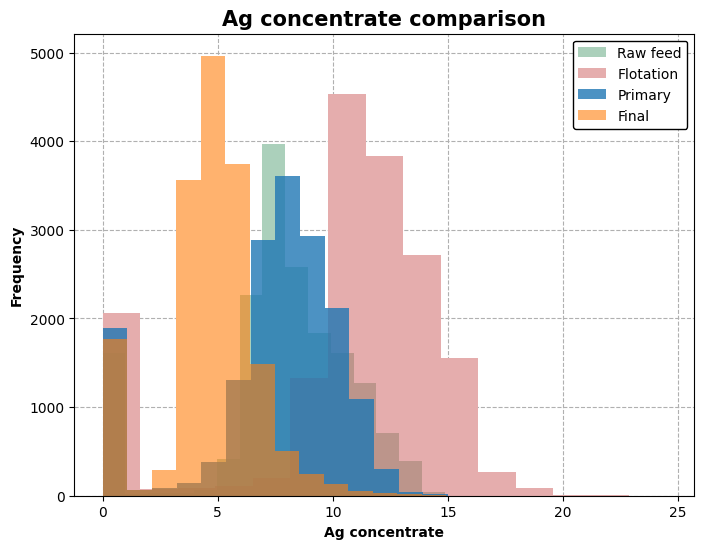

In [16]:
# Create plot figure and subplot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# Add histograms for background, primary cleaner, and final
ax.hist(gold_train['rougher.input.feed_ag'], color='white', bins=15)
ax.hist(gold_train['rougher.output.concentrate_ag'], color='white', bins=15)
ax.hist(gold_train['primary_cleaner.output.concentrate_ag'], color='white', bins=15)
ax.hist(gold_train['final.output.concentrate_ag'], color='white', bins=15)
ax.hist(gold_train['rougher.input.feed_ag'], label='Raw feed', color='seagreen', bins=15, alpha=0.4)
ax.hist(gold_train['rougher.output.concentrate_ag'], label='Flotation', color='indianred', bins=15, alpha=0.5)
ax.hist(gold_train['primary_cleaner.output.concentrate_ag'], label='Primary', bins=15, alpha=0.8)
ax.hist(gold_train['final.output.concentrate_ag'], label='Final', bins=15, alpha=0.6)

# Add grid and set below figure
ax.grid(True, axis='both', linestyle='dashed')
ax.set_axisbelow(True)

# Add legend and labels
plt.legend(facecolor='white', framealpha=1, edgecolor='black')
plt.title('Ag concentrate comparison', fontsize=15, fontweight='bold')
plt.xlabel('Ag concentrate', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')
plt.show()

#### Pb concentrations by stage

The Pb concentrate distribution is a bit different. There is not a clear increase or decrease in values bewteen the primary and final stages, but there are less bigger concentrations after the final stage. There are much less concentrations over 12.5 and more intermediate values after the final stage.

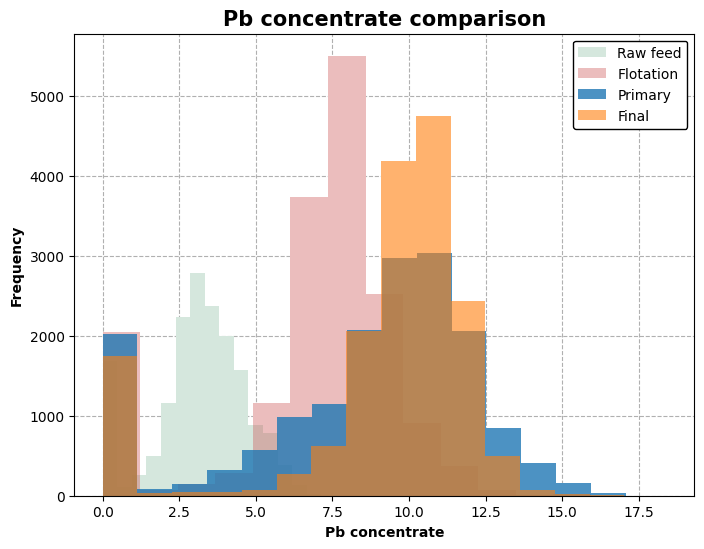

In [17]:
# Create plot figure and subplot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# Add histograms for background, primary cleaner, and final
ax.hist(gold_train['rougher.input.feed_pb'], color='white', bins=15)
ax.hist(gold_train['rougher.output.concentrate_pb'], color='white', bins=15)
ax.hist(gold_train['primary_cleaner.output.concentrate_pb'], color='white', bins=15)
ax.hist(gold_train['final.output.concentrate_pb'], color='white', bins=15)
ax.hist(gold_train['rougher.input.feed_pb'], label='Raw feed', color='seagreen', bins=15, alpha=0.2)
ax.hist(gold_train['rougher.output.concentrate_pb'], label='Flotation', color='indianred', bins=15, alpha=0.4)
ax.hist(gold_train['primary_cleaner.output.concentrate_pb'], label='Primary', bins=15, alpha=0.8)
ax.hist(gold_train['final.output.concentrate_pb'], label='Final', bins=15, alpha=0.6)

# Add grid and set below figure
ax.grid(True, axis='both', linestyle='dashed')
ax.set_axisbelow(True)

# Add legend and labels
plt.legend(facecolor='white', framealpha=1, edgecolor='black')
plt.title('Pb concentrate comparison', fontsize=15, fontweight='bold')
plt.xlabel('Pb concentrate', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')
plt.show()

#### Au concentrations by stage

Similar theme to the oveview tables. The histogram shows a steep <b>increase</b> of Au concentrations during the refining process. The primary stage has much lower concentrations, and as the process ends, the final stage has much higher concentrations, which is what was expected.

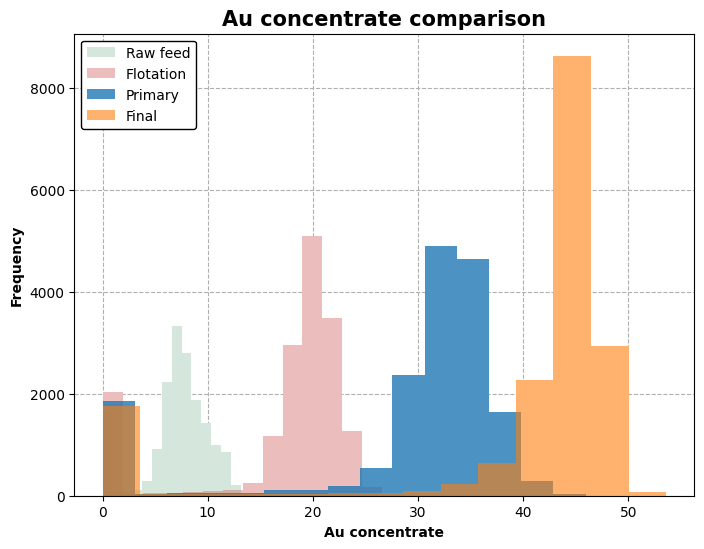

In [18]:
# Create plot figure and subplot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# Add histograms for background, primary cleaner, and final
ax.hist(gold_train['rougher.input.feed_au'], color='white', bins=15)
ax.hist(gold_train['rougher.output.concentrate_au'], color='white', bins=15)
ax.hist(gold_train['primary_cleaner.output.concentrate_au'], color='white', bins=15)
ax.hist(gold_train['final.output.concentrate_au'], color='white', bins=15)
ax.hist(gold_train['rougher.input.feed_au'], label='Raw feed', color='seagreen', bins=15, alpha=0.2)
ax.hist(gold_train['rougher.output.concentrate_au'], label='Flotation', color='indianred', bins=15, alpha=0.4)
ax.hist(gold_train['primary_cleaner.output.concentrate_au'], label='Primary', bins=15, alpha=0.8)
ax.hist(gold_train['final.output.concentrate_au'], label='Final', bins=15, alpha=0.6)

# Add grid and set below figure
ax.grid(True, axis='both', linestyle='dashed')
ax.set_axisbelow(True)

# Add legend and labels
plt.legend(facecolor='white', framealpha=1, loc='upper left', edgecolor='black')
plt.title('Au concentrate comparison', fontsize=15, fontweight='bold')
plt.xlabel('Au concentrate', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')
plt.show()

#### All elements comparison

The histogram below is a blend of all the distributions, providing a clearer comparison for analysis among all the metals (Ag, Pb, Au).

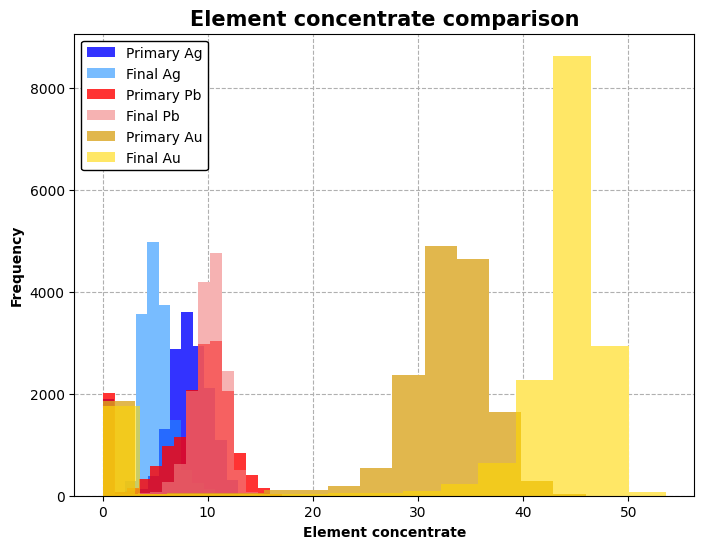

In [19]:
# Create plot figure and subplot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# Add histograms for background, primary cleaner, and final for all elements
ax.hist(gold_train['primary_cleaner.output.concentrate_ag'], color='white', bins=15)
ax.hist(gold_train['final.output.concentrate_ag'], color='white', bins=15)
ax.hist(gold_train['primary_cleaner.output.concentrate_pb'], color='white', bins=15)
ax.hist(gold_train['final.output.concentrate_pb'], color='white', bins=15)
ax.hist(gold_train['primary_cleaner.output.concentrate_au'], color='white', bins=15)
ax.hist(gold_train['final.output.concentrate_au'], color='white', bins=15)
ax.hist(gold_train['primary_cleaner.output.concentrate_ag'], label='Primary Ag', bins=15, alpha=0.8, color='blue')
ax.hist(gold_train['final.output.concentrate_ag'], label='Final Ag', bins=15, alpha=0.6, color='dodgerblue')
ax.hist(gold_train['primary_cleaner.output.concentrate_pb'], label='Primary Pb', bins=15, alpha=0.8, color='red')
ax.hist(gold_train['final.output.concentrate_pb'], label='Final Pb', bins=15, alpha=0.6, color='lightcoral')
ax.hist(gold_train['primary_cleaner.output.concentrate_au'], label='Primary Au', bins=15, alpha=0.8, color='goldenrod')
ax.hist(gold_train['final.output.concentrate_au'], label='Final Au', bins=15, alpha=0.6, color='gold')

# Add grid and set below figure
ax.grid(True, axis='both', linestyle='dashed')
ax.set_axisbelow(True)

# Add legend and labels
plt.legend(facecolor='white', framealpha=1, loc='upper left', edgecolor='black')
plt.title('Element concentrate comparison', fontsize=15, fontweight='bold')
plt.xlabel('Element concentrate', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')
plt.show()

#### Mean concentration by stage

The bar chart provides concrete quantative analysis regarding the difference in average concentration by stage, putting hard numbers to the trends in the distribution from the histograms. The chart below provides a summary of the differences, but the mean values are also listed below.

- <b>Ag</b>
    - _Raw feed_: 8.41
    - _Rougher_: 11.66
    - _Primary_: 8.03
    - _Final_: 5.08
    - _Trend_: Decrease
- <b>Pb</b>
    - _Raw feed_: 3.44
    - _Rougher_: 7.57
    - _Primary_: 9.26
    - _Final_: 9.86
    - _Trend_: Increase
- <b>Au</b>
    - _Raw feed_: 7.7
    - _Rougher_: 19.15
    - _Primary_: 31.45
    - _Final_: 42.76
    - _Trend_: Increase

Ag
Raw feed mean: 7.8
After flotation mean: 10.54
After primary clean mean: 7.39
After secondary clean mean: 4.7

Pb
Raw feed mean: 3.19
After flotation mean: 6.86
After primary clean mean: 8.49
After secondary clean mean: 9.08

Au
Raw feed mean: 7.14
After flotation mean: 17.34
After primary clean mean: 29.04
After secondary clean mean: 39.32


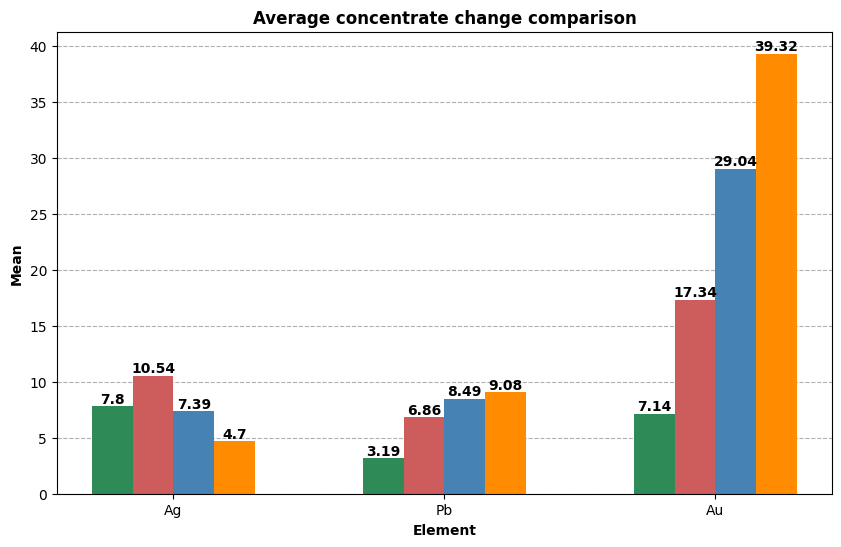

In [20]:
# Create plot figure and subplot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

# Calculate means for primary cleaner and final for all elements
raw_ag_mean = round(gold_train['rougher.input.feed_ag'].mean(), 2)
rc_ag_mean = round(gold_train['rougher.output.concentrate_ag'].mean(), 2)
pc_ag_mean = round(gold_train['primary_cleaner.output.concentrate_ag'].mean(), 2)
f_ag_mean = round(gold_train['final.output.concentrate_ag'].mean(), 2)
raw_pb_mean = round(gold_train['rougher.input.feed_pb'].mean(), 2)
rc_pb_mean = round(gold_train['rougher.output.concentrate_pb'].mean(), 2)
pc_pb_mean = round(gold_train['primary_cleaner.output.concentrate_pb'].mean(), 2)
f_pb_mean = round(gold_train['final.output.concentrate_pb'].mean(), 2)
raw_au_mean = round(gold_train['rougher.input.feed_au'].mean(), 2)
rc_au_mean = round(gold_train['rougher.output.concentrate_au'].mean(), 2)
pc_au_mean = round(gold_train['primary_cleaner.output.concentrate_au'].mean(), 2)
f_au_mean = round(gold_train['final.output.concentrate_au'].mean(), 2)

# Display results
print('\033[4mAg\033[0m')
print('Raw feed mean:', raw_ag_mean)
print('After flotation mean:', rc_ag_mean)
print('After primary clean mean:', pc_ag_mean)
print('After secondary clean mean:', f_ag_mean)
print()
print('\033[4mPb\033[0m')
print('Raw feed mean:', raw_pb_mean)
print('After flotation mean:', rc_pb_mean)
print('After primary clean mean:', pc_pb_mean)
print('After secondary clean mean:', f_pb_mean)
print()
print('\033[4mAu\033[0m')
print('Raw feed mean:', raw_au_mean)
print('After flotation mean:', rc_au_mean)
print('After primary clean mean:', pc_au_mean)
print('After secondary clean mean:', f_au_mean)

# Create labels, x axis position, and list of means variables
x = np.arange(3)
xlabels = ['Ag', 'Pb', 'Au']
xpositions = [0, 1, 2]
raw_feed_means = [raw_ag_mean, raw_pb_mean, raw_au_mean]
flotation_means = [rc_ag_mean, rc_pb_mean, rc_au_mean]
primary_means = [pc_ag_mean, pc_pb_mean, pc_au_mean]
final_means = [f_ag_mean, f_pb_mean, f_au_mean]
width = 0.15

# Plot bar charts - bars for the primary cleaner means and final means
plt.bar(x-0.225, raw_feed_means, width, color='seagreen')
plt.bar(x-0.075, flotation_means, width, color='indianred')
plt.bar(x+0.075, primary_means, width, color='steelblue')
plt.bar(x+0.225, final_means, width, color='darkorange')


# Add legend and labels
plt.title('Average concentrate change comparison', fontsize=12, fontweight='bold')
plt.xlabel('Element', fontweight='bold')
plt.ylabel('Mean', fontweight='bold')
plt.xticks(xpositions, xlabels)

# Update colors of bars
# raw_feed = mpatches.Patch(color='blueviolet', label = 'Raw feed')
# flotation = mpatches.Patch(color='indianred', label='After flotation')
# primary = mpatches.Patch(color='steelblue', label='After primary clean')
# final = mpatches.Patch(color='darkorange', label='After secondary clean (final)')
# plt.legend(handles=[raw_feed, flotation, primary, final], framealpha=1, edgecolor='black')

for i in range(len(xlabels)):
    plt.text(i-0.225, raw_feed_means[i], raw_feed_means[i], ha='center', va='bottom', weight='bold')
    plt.text(i-0.075, flotation_means[i], flotation_means[i], ha='center', va='bottom', weight='bold')
    plt.text(i+0.075, primary_means[i], primary_means[i], ha='center', va='bottom', weight='bold')
    plt.text(i+0.225, final_means[i], final_means[i], ha='center', va='bottom', weight='bold')

# Add grid and set below figure
ax.grid(True, axis='y', linestyle='dashed')
ax.set_axisbelow(True)

### Feed particle size distributions

#### Overview

It is important that the feed particle sizes between the training and test datasets be analyzed. If the values vary significantly between the datasets, the model evaluation could be incorrect or misleading. An initial look into the feed sizes, rougher feed size and primary cleaner feed size, shows that the values do not notably vary, but it is a very small sample size, only 10 records. Just an initial look is not going to suffice.

In [21]:
# Filter for feed size columns in both datasets
size_filter_train = gold_train.filter(regex='size')
print()
print('TRAINING')
display(size_filter_train.head(10))
size_filter_test = gold_test.filter(regex='size')
print()
print('TEST')
display(size_filter_test.head(10))


TRAINING


,primary_cleaner.input.feed_size,rougher.input.feed_size
0,7.25,55.486599
1,7.25,57.278666
2,7.25,57.510649
3,7.25,57.792734
4,7.25,56.047189
5,7.25,57.469578
6,7.25,56.674647
7,7.25,56.730325
8,7.25,56.649893
9,7.25,58.509262



TEST


,primary_cleaner.input.feed_size,rougher.input.feed_size
0,8.080000,62.710452
1,8.080000,61.961163
2,7.786667,66.903807
3,7.640000,59.865919
4,7.530000,63.315324
5,7.420000,69.218255
6,7.420000,75.856243
7,6.988000,77.968131
8,6.935000,75.846999
9,7.030000,72.476418


#### Rougher feed size comparison

The histogram below displays the distribution of rougher feed sizes between the training and test datasets. Because the training dataset has many more observations than the test dataset, the histogram was normalized. So, the total area under the histogram equals to 1 for both datasets and the y-axis acts a percentage.

The distribution is very similar between the 2 datasets. Most of the feed size values for both datasets are in the third bin in the 25-50 range, followed by the 50-75 range with the second most bunch of values. The feed sizes do not vary to a degree of concern.

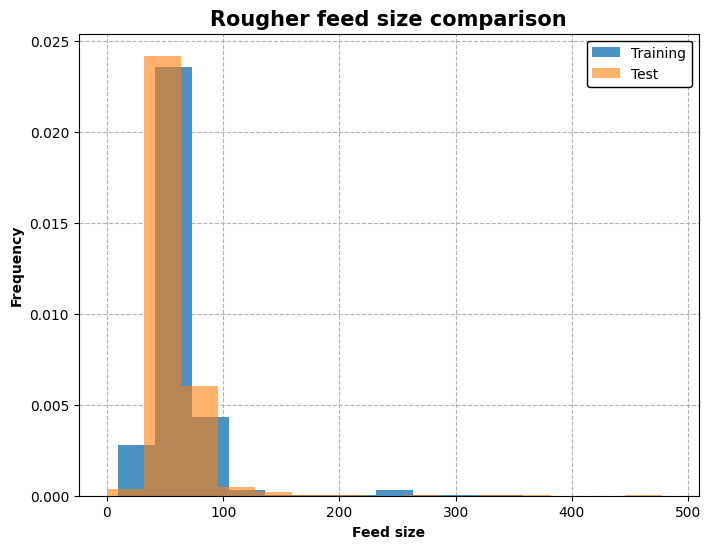

In [22]:
# Create plot figure and subplot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# Add histograms for training and test datasets
ax.hist(gold_train['rougher.input.feed_size'], color='white', bins=15, density=True)
ax.hist(gold_test['rougher.input.feed_size'], color='white', bins=15, density=True)
ax.hist(gold_train['rougher.input.feed_size'], label='Training', bins=15, alpha=0.8, density=True)
ax.hist(gold_test['rougher.input.feed_size'], label='Test', bins=15, alpha=0.6, density=True)

# Add grid and set below figure
ax.grid(True, axis='both', linestyle='dashed')
ax.set_axisbelow(True)

# Add legend and labels
plt.legend(facecolor='white', framealpha=1, edgecolor='black')
plt.title('Rougher feed size comparison', fontsize=15, fontweight='bold')
plt.xlabel('Feed size', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')
plt.show()

#### Primary cleaner feed size comparison

The comparison of primary cleaner feed sizes presents a similar theme. Most of the feed size values are all bunched within the 6 and 10 range, with the highest of values being around 8 for both datasets. The primary cleaner feed sizes also do not vary to a degree of concern.

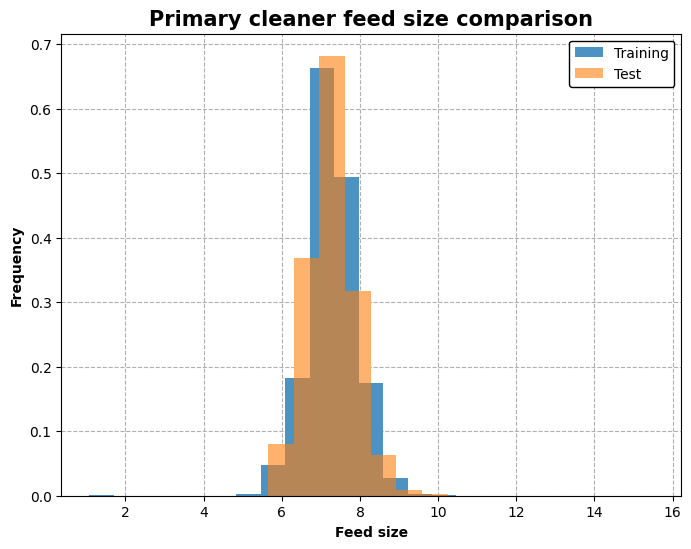

In [24]:
# Create plot figure and subplot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# Add histograms for training and test datasets
ax.hist(gold_train['primary_cleaner.input.feed_size'], color='white', bins=15, density=True)
ax.hist(gold_test['primary_cleaner.input.feed_size'], color='white', bins=15, density=True)
ax.hist(gold_train['primary_cleaner.input.feed_size'], label='Training', bins=15, alpha=0.8, density=True)
ax.hist(gold_test['primary_cleaner.input.feed_size'], label='Test', bins=15, alpha=0.6, density=True)

# Add grid and set below figure
ax.grid(True, axis='both', linestyle='dashed')
ax.set_axisbelow(True)

# Add legend and labels
plt.legend(facecolor='white', framealpha=1, edgecolor='black')
plt.title('Primary cleaner feed size comparison', fontsize=15, fontweight='bold')
plt.xlabel('Feed size', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')
plt.show()

#### All feed size comparison

The side by side box plot comparison further displays the distribution of feed sizes of the rougher and primary cleaner stages. The box plot quartile and mean marks are nearly identical, implying an even distribution between the two datasets. Note the box plots do not show outliers.

/tmp/ipykernel_630/1316920941.py:27: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(4)


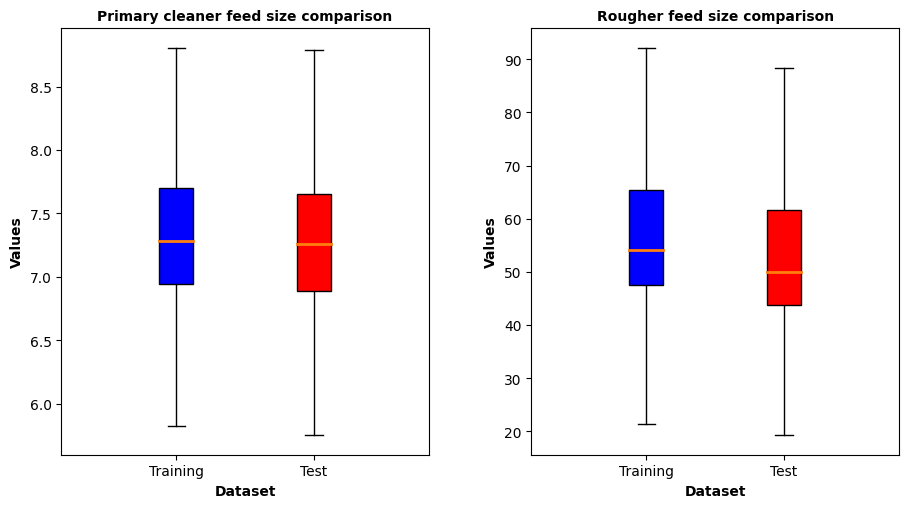

In [25]:
# Create plot figure and subplot
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)

# Add box plot for primary cleaner feed sizes
pc_box = plt.boxplot([gold_train['primary_cleaner.input.feed_size'], gold_test['primary_cleaner.input.feed_size']], 
            labels=['Training', 'Test'], positions=[0, 0.6], showfliers=False, patch_artist=True, medianprops={'linewidth': 2})
plt.title('Primary cleaner feed size comparison', fontsize=10, fontweight='bold')
plt.xlabel('Dataset', fontweight='bold')
plt.ylabel('Values', fontweight='bold')

# Add box plot for rougher feed sizes
plt.subplot(1, 2, 2)
r_box = plt.boxplot([gold_train['rougher.input.feed_size'], gold_test['rougher.input.feed_size']], 
            labels=['Training', 'Test'], positions=[0, 0.6], showfliers=False, patch_artist=True, medianprops={'linewidth': 2})
plt.title('Rougher feed size comparison', fontsize=10, fontweight='bold')
plt.xlabel('Dataset', fontweight='bold')
plt.ylabel('Values', fontweight='bold')

# Update colors of box plots
colors = ['blue', 'red']
for bplot in (pc_box, r_box):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

# Display box plots
plt.tight_layout(4)
plt.show()

### Outliers

#### Outlier analysis: Sum of concentrations for all elements

There will be fluctuations in the concentrations throughout the refining process, but the total sum of concentrations for all elements in a particular stage should <b>always be above 0</b>. For example, at a particular time, let's say on 3/1 @ 3 PM, the rougher output concentrations for each element are measured. The contents and makeup of the ore mixture @ 3 PM might have lower concentrations of Ag and Pb, and higher concentrations of Sol and Au, or vice versa, or it might have some other combination of highs vs lows. But never should the total concentration of all 4 elements be 0. That is just not possible. There will always be some amount or concentration of an element.

The histogram below reveals the presence of many total concentrations that sum up to 0. Nearly 2000 records. These zero sum values are probably a result of instrumentation or recording failures at specific times. But nonetheless, as it was just described this is not a possibility, these records have been removed from the dataset to prevent inaccuracies in future modeling.  

In [26]:
# Calculate the sum of total concentrations of all elements for rougher input, rougher output, and final output
gold_train['rougher.input.concentrate_sum'] = gold_train['rougher.input.feed_ag'] + gold_train['rougher.input.feed_pb'] + gold_train['rougher.input.feed_sol'] + gold_train['rougher.input.feed_au']
gold_train['rougher.output.concentrate_sum'] = gold_train['rougher.output.concentrate_ag'] + gold_train['rougher.output.concentrate_pb'] + gold_train['rougher.output.concentrate_sol'] + gold_train['rougher.output.concentrate_au']
gold_train['final.output.concentrate_sum'] = gold_train['final.output.concentrate_ag'] + gold_train['final.output.concentrate_pb'] + gold_train['final.output.concentrate_sol'] + gold_train['final.output.concentrate_au']

# Display results
print('\033[4mTotal records with a zero sum of total concentrations\033[0m')
print('Rougher input:', len(gold_train[gold_train['rougher.input.concentrate_sum'] == 0]))
print('Rougher output:', len(gold_train[gold_train['rougher.output.concentrate_sum'] == 0]))
print('Final output:', len(gold_train[gold_train['final.output.concentrate_sum'] == 0]))

Total records with a zero sum of total concentrations
Rougher input: 1213
Rougher output: 1547
Final output: 1320


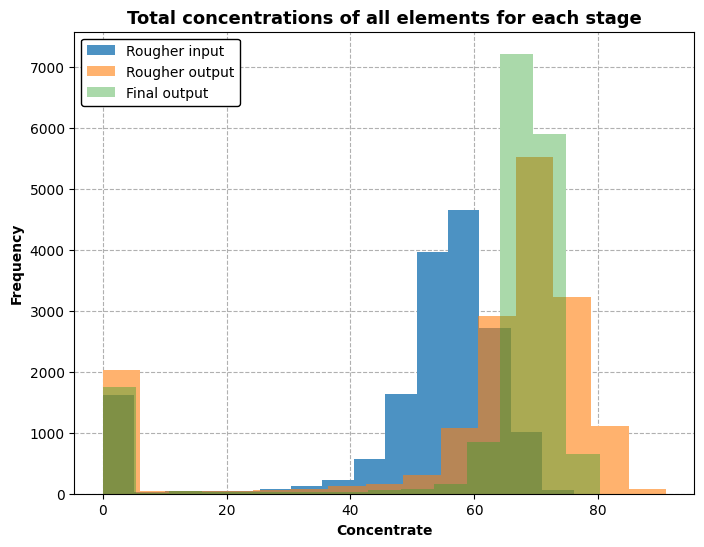

In [27]:
# Create plot figure and subplot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# Add histograms for background and all stages
ax.hist(gold_train['rougher.input.concentrate_sum'], color='white', bins=15)
ax.hist(gold_train['rougher.output.concentrate_sum'], color='white', bins=15)
ax.hist(gold_train['final.output.concentrate_sum'], color='white', bins=15)
ax.hist(gold_train['rougher.input.concentrate_sum'], label='Rougher input', bins=15, alpha=0.8)
ax.hist(gold_train['rougher.output.concentrate_sum'], label='Rougher output', bins=15, alpha=0.6)
ax.hist(gold_train['final.output.concentrate_sum'], label='Final output', bins=15, alpha=0.4)

# Add grid and set below figure
ax.grid(True, axis='both', linestyle='dashed')
ax.set_axisbelow(True)

# Add legend and labels
plt.legend(facecolor='white', framealpha=1, edgecolor='black')
plt.title('Total concentrations of all elements for each stage', fontsize=13, fontweight='bold')
plt.xlabel('Concentrate', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')
plt.show()

#### Remove outliers

In [28]:
# Display old length of dataset
print('Old length of training dataset', len(gold_train))

# Remove outliers
# NOTE: rougher.output.recovery and final.output.recovery are also included. Zero values in these columns cause
# mathmatical errors when calulcating the sMAPE
zero_values = gold_train[(gold_train['rougher.input.concentrate_sum'] == 0) | (gold_train['rougher.output.concentrate_sum'] == 0) | 
                  (gold_train['final.output.concentrate_sum'] == 0) | (gold_train['rougher.output.recovery'] == 0) | (gold_train['final.output.recovery'] == 0)]

gold_train.drop(zero_values.index, inplace=True)
gold_train = gold_train.reset_index(drop=True)

# Display new length of dataset
print('New length of training dataset:', len(gold_train))

Old length of training dataset 16860
New length of training dataset: 15086


## Model preparation

There were a few preparation tasks that needed to be performed before training and building models could occur. These tasks included:

- Create a sMAPE calculation function
- Split data into training and validation datasets
- Determine features and targets
- Implement feature scaling on the data

### sMAPE calculation function

A function for calculating the symmetric mean absolute percentage error (<b>sMAPE</b>) was created to evaluate model performance. The function includes calculations for the sMAPE of the rougher output recovery, final output recovery, and then total sMAPE. The final calculation is total <mark>sMAPE =  25% * rougher sMAPE + 75% * final sMAPE</mark>.

In [80]:
# Create a function that calculates the sMAPE
def calculate_sMAPE(target, preds, scorer=False):
    column_names = ['rougher_recovery', 'final_recovery']
    predictions = pd.DataFrame(preds, columns=column_names)

    rougher_target = list(target['rougher.output.recovery'])
    rougher_preds = list(predictions['rougher_recovery'])
    final_target = list(target['final.output.recovery'])
    final_preds = list(predictions['final_recovery'])

    rougher_values = []
    final_values = []

    for i in range(len(rougher_target)):
        rougher_value = abs(rougher_target[i] - rougher_preds[i]) / ((abs(rougher_target[i]) + abs(rougher_preds[i])) / 2) 
        rougher_values.append(rougher_value)
    sum_rougher = sum(rougher_values)
    rougher_sMAPE = sum_rougher / len(rougher_target) * 100
    for k in range(len(final_target)):
        final_value = abs(final_target[k] - final_preds[k]) / ((abs(final_target[k]) + abs(final_preds[k])) / 2)
        final_values.append(final_value)
    sum_final = sum(final_values)
    final_sMAPE = sum_final / len(final_target) * 100
    sMAPE = round(((0.25 * rougher_sMAPE) + (0.75 * final_sMAPE)), 5)
    
    if scorer == False:
        return rougher_sMAPE, final_sMAPE, sMAPE
    else:
        return sMAPE

In [81]:
# Test function
test_tar = pd.DataFrame({'rougher.output.recovery': [1, 2, 3, 4], 'final.output.recovery': [2, 3, 4, 6]})
test_preds = pd.DataFrame({'rougher_recovery': [2, 3, 4, 6], 'final_recovery': [2, 3, 5, 6]})

test_sMAPE = calculate_sMAPE(test_tar, test_preds, scorer=False)
print('Rougher sMAPE:', test_sMAPE[0])
print('Final sMAPE:', test_sMAPE[1])
print('sMAPE:', test_sMAPE[2])

Rougher sMAPE: 43.80952380952381
Final sMAPE: 5.555555555555555
sMAPE: 15.11905


### Custom scorer

In [82]:
# # Create custom scorer for model evaluation
custom_scorer = make_scorer(calculate_sMAPE, greater_is_better=False, scorer=True)

### Training and validation datasets

The training dataset was split into a training and validation dataset with a 80 / 20 split. The validation dataset will be used to evaluate the model performance after predictions and for fine-tuning the model. The split also ensures that there is ample data for the model to be properly trained.

In [83]:
# Split training dataset into training and validation datasets
gold_training, gold_valid = train_test_split(gold_train, test_size=0.2, random_state=123)

### Features and targets

Seeing that the test dataset is missing certain parameters compared to the training dataset, these parameters were NOT be included as features for training the model. So, these parameters have been removed from the dataset. The list of features are include all columns in the test dataset, excluding <b><mark>date</mark></b>. The targets are the output recoveries. They are both listed below.

<b>Features</b>

- <mark>primary_cleaner.input.sulfate
- <mark>primary_cleaner.input.depressant
- <mark>primary_cleaner.input.feed_size
- <mark>primary_cleaner.input.xanthate
- <mark>primary_cleaner.state.floatbank8_a_air
- <mark>primary_cleaner.state.floatbank8_a_level
- <mark>primary_cleaner.state.floatbank8_b_air
- <mark>primary_cleaner.state.floatbank8_b_level
- <mark>primary_cleaner.state.floatbank8_c_air
- <mark>primary_cleaner.state.floatbank8_c_level
- <mark>primary_cleaner.state.floatbank8_d_air
- <mark>primary_cleaner.state.floatbank8_d_level
- <mark>rougher.input.feed_ag
- <mark>rougher.input.feed_pb
- <mark> rougher.input.feed_rate
- <mark>rougher.input.feed_size
- <mark>rougher.input.feed_sol
- <mark>rougher.input.feed_au
- <mark>rougher.input.floatbank10_sulfate
- <mark>rougher.input.floatbank10_xanthate
- <mark>rougher.input.floatbank11_sulfate
- <mark>rougher.input.floatbank11_xanthate
- <mark>rougher.state.floatbank10_a_air
- <mark>rougher.state.floatbank10_a_level
- <mark>rougher.state.floatbank10_b_air
- <mark>rougher.state.floatbank10_b_level
- <mark>rougher.state.floatbank10_c_air
- <mark>rougher.state.floatbank10_c_level
- <mark>rougher.state.floatbank10_d_air
- <mark>rougher.state.floatbank10_d_level
- <mark>rougher.state.floatbank10_e_air
- <mark>rougher.state.floatbank10_e_level
- <mark>rougher.state.floatbank10_f_air
- <mark>rougher.state.floatbank10_f_level
- <mark>secondary_cleaner.state.floatbank2_a_air
- <mark>secondary_cleaner.state.floatbank2_a_level
- <mark>secondary_cleaner.state.floatbank2_b_air
- <mark>secondary_cleaner.state.floatbank2_b_level
- <mark>secondary_cleaner.state.floatbank3_a_air
- <mark>secondary_cleaner.state.floatbank3_a_level
- <mark>secondary_cleaner.state.floatbank3_b_air
- <mark>secondary_cleaner.state.floatbank3_b_level
- <mark>secondary_cleaner.state.floatbank4_a_air
- <mark>secondary_cleaner.state.floatbank4_a_level
- <mark>secondary_cleaner.state.floatbank4_b_air
- <mark>secondary_cleaner.state.floatbank4_b_level
- <mark>secondary_cleaner.state.floatbank5_a_air
- <mark>secondary_cleaner.state.floatbank5_a_level
- <mark>secondary_cleaner.state.floatbank5_b_air
- <mark>secondary_cleaner.state.floatbank5_b_level
- <mark>secondary_cleaner.state.floatbank6_a_air
- <mark>secondary_cleaner.state.floatbank6_a_level



<b>Targets</b>

- <mark>rougher.output.recovery
- <mark>final.output.recovery

In [84]:
# Define target and features variables
gold_training_features = gold_training.drop(missing_parameters, axis=1)
other_cols = ['date', 'rougher.input.concentrate_sum', 'rougher.output.concentrate_sum', 'final.output.concentrate_sum']
gold_training_features = gold_training_features.drop(columns=other_cols, axis=1)
gold_training_target = gold_training[['rougher.output.recovery', 'final.output.recovery']]

gold_valid_features = gold_valid.drop(missing_parameters, axis=1)
gold_valid_features = gold_valid_features.drop(columns=other_cols, axis=1)
gold_valid_target = gold_valid[['rougher.output.recovery', 'final.output.recovery']]

<div class="alert alert-block alert-success">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>

Good job!
  
</div>

### Feature scaling

Some of the features contain values that are much higher or lower than other features. What this could lead to is the learning algorithm giving much more weight and influence to certain features since has it has much higher or lower values, even though this is not the case in reality. Therefore, feature scaling has been performed to account for these variances of values.

In [85]:
# Get lists of features to standardize 
standardize_list_train = gold_training_features.columns.tolist()
standardize_list_valid = gold_valid_features.columns.tolist()

# Create instance of scaler class and standardize features
scaler = StandardScaler()

scaler.fit(gold_training_features[standardize_list_train])
scaler.fit(gold_valid_features[standardize_list_valid])

gold_training_features[standardize_list_train] = scaler.transform(gold_training_features[standardize_list_train])
gold_valid_features[standardize_list_valid] = scaler.transform(gold_valid_features[standardize_list_valid])

# Display standardized DataFrames
display(gold_training_features.head())
display(gold_valid_features.head())

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
7741,-2.371925,-2.267586,-2.350376,-1.928198,0.709178,-0.067679,0.660998,-0.075638,0.658279,-0.081549,...,0.842992,1.294599,1.396872,0.938648,1.576579,0.780726,1.462307,0.700146,1.772762,0.218470
12856,-2.857087,-2.270088,-0.724454,-2.094073,0.865280,-0.100675,0.856959,-0.079402,0.840200,-0.127756,...,1.655222,1.323377,1.199968,-0.699935,1.404847,-0.235241,1.708697,-0.157611,0.963213,0.191875
10722,0.488451,-0.154152,0.820173,2.489854,0.477027,-0.108342,0.469262,-0.060741,0.458717,-0.105720,...,0.008659,-0.265770,-0.081833,-0.495493,-0.901166,-0.187042,-0.661445,-0.165307,-1.315316,0.131436
8218,-0.704492,0.909912,0.332396,0.371592,0.470967,-0.071680,0.477570,-0.062849,0.459105,-0.107419,...,-0.310754,-0.204560,-0.431530,1.233939,0.257409,-0.163690,0.018301,-0.157095,0.147519,0.231849
8571,-0.535613,-0.185562,-0.643157,-0.855571,0.473524,-0.098477,0.470218,-0.077154,0.458988,-0.093751,...,-0.313258,-0.233797,-0.446259,1.225255,0.252450,-0.179674,0.015537,-0.158814,-0.659879,0.199872


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
9287,-0.438900,-0.551823,1.600615,-1.247725,-0.673580,-0.091041,-0.675866,-0.087119,-0.670024,-0.208259,...,-1.123538,-0.224616,-0.980502,0.941709,-1.389092,-0.188867,-0.495035,-0.157712,-2.129486,0.219940
12510,-2.231572,-1.585307,-1.700007,1.109439,0.478261,-0.089834,0.469823,-0.077128,0.457669,-0.088547,...,1.661690,-0.245181,0.830319,-0.491830,1.405677,-0.182414,1.712725,-0.158863,0.959565,0.207253
9642,1.276208,-0.678753,-0.261067,-0.759961,-0.875083,-0.092684,-0.858912,-0.064505,-0.845004,-0.107620,...,-0.888263,-0.172744,-0.813650,0.933367,-0.400530,-0.222346,-0.318787,0.000542,-0.661673,0.191498
5603,0.648474,0.506606,-0.610639,2.333375,0.087323,-0.098082,0.075727,-0.075024,0.087440,-0.073058,...,0.843896,-0.242696,1.397891,-0.503666,1.081990,-0.171934,1.200325,-0.156168,0.964606,-1.675684
8800,-0.422220,-0.692284,-0.594380,0.275664,0.488095,-0.100802,0.511524,-0.076698,0.462183,-0.098311,...,0.342224,-0.241581,-0.073008,1.177661,0.256235,-0.182118,0.032092,-0.160149,-0.660957,0.214796


## Model building

There were 4 different models built to predict the output recoveries after the rougher and final stages of the refining process. The models include <b>multiple linear regression</b>, <b>K-nearest neighbors</b>, <b>support vector regression</b>, and <b>ridge regression</b>. Each model was initally run without no fine-tuning and optimizations. After evaluation and optimization, each model was ran again with new parameters and fine-tuning.

1. You don't need to use kwargs. And you're right about the number of inputs. Your function must accept only two arguments: targets and predictions. But targets and predictions can be not vectors but matrices. I mean that targets can have shape (N, 2) but not (N, 1). And inside the function you can split this matrix into 2 different target columns. So, it's not necessary to pass each target separately. You can pass them as a single (N, 2) matrix. And the same is for predictions.

### Multiple linear regression

The mulitple linear regresion model yielded the following results. The non-optimized model was almost completely optimized from a hyperparameter tuning perspective. Only one of the parameters was upated from its default value, and the total sMAPE did not change.

- <b>Non-optimized</b>
    - _Rougher sMAPE_: 5.35195
    - _Final sMAPE_: 9.79825
    - _Total sMAPE_: <b><mark>8.68667</mark></b>
    
- <b>Best estimator parameters</b>
    - _copy X_: True
    - _fit intercept_: True
    - _n jobs_: 1
    - _positive_: False
- <b>Optimized</b>
    - _Rougher sMAPE_: 5.35195
    - _Final sMAPE_: 9.79825
    - _Total sMAPE_: <b><mark>8.68667</mark></b>

#### Non-optimized model

In [89]:
# Create model and retrieve cross-validation score with 5 folds
linear_model = LinearRegression()
scores_train = cross_val_score(linear_model, gold_training_features, gold_training_target, cv=5, scoring=custom_scorer)
final_score = sum(scores_train) / len(scores_train)
print('Average model evaluation score:', abs(round(final_score, 5)))

Average model evaluation score: 8.68606


In [90]:
# Train model
start = datetime.now()
linear_model.fit(gold_training_features, gold_training_target)

# Gather model predictions
predictions = linear_model.predict(gold_valid_features)
stop = datetime.now()
delta = stop - start

# Calculate sMAPE
# Reset index of target dataset
gold_valid_target = gold_valid_target.reset_index(drop=True)

# Display sMAPE results
total_sMAPE = calculate_sMAPE(gold_valid_target, predictions, scorer=False)
print('Rougher sMAPE:', total_sMAPE[0])
print('Final sMAPE:', total_sMAPE[1])
print('sMAPE:', total_sMAPE[2])
seconds = delta.seconds + delta.microseconds/1E6
print('Time to compute:', seconds, 'seconds')

Rougher sMAPE: 5.351950789721598
Final sMAPE: 9.798246719049713
sMAPE: 8.68667
Time to compute: 0.027852 seconds


#### Optimized model

In [91]:
# Set parameter grid
param_grid = {'copy_X': [True, False], 'fit_intercept': [True, False], 
              'n_jobs': [1, 5, 10, 15, None], 'positive': [True, False]}

# Create grid search object
grid_search = GridSearchCV(linear_model, param_grid, cv=5, scoring=custom_scorer3)

# Train model
grid_search.fit(gold_training_features, gold_training_target)

# Display best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {abs(grid_search.best_score_)}")
print(f"Best estimator: {grid_search.best_estimator_}")

Best parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': 1, 'positive': False}
Best score: 8.686060000000001
Best estimator: LinearRegression(n_jobs=1)


In [78]:
# Train model
linear_model = grid_search.best_estimator_
start = datetime.now()
linear_model.fit(gold_training_features, gold_training_target)

# Gather model predictions
predictions = linear_model.predict(gold_valid_features)
stop = datetime.now()
delta = stop - start

# Calculate and display sMAPE results
total_sMAPE = calculate_sMAPE(gold_valid_target, predictions)
print('Rougher sMAPE:', total_sMAPE[0])
print('Final sMAPE:', total_sMAPE[1])
print('sMAPE:', total_sMAPE[2])
seconds = delta.seconds + delta.microseconds/1E6
print('Time to compute:', seconds, 'seconds')

Rougher sMAPE: 5.351950789721598
Final sMAPE: 9.798246719049713
sMAPE: 8.68667
Time to compute: 0.022363 seconds


### K-nearest neighbors

The K-nearest neighbors model yielded the following results. The optimization did improve the model performance, resulting in a 0.5 total sMAPE decrease.

- <b>Non-optimized</b>
    - _Rougher sMAPE_: 2.87787
    - _Final sMAPE_: 6.08316
    - _Total sMAPE_: <b><mark>5.28184</mark></b>
    
- <b>Best estimator parameters</b>
    - _n jobs_: 1
    - _n neighbors_: 3
    - _weight_: distance
    - _p_: 1
- <b>Optimized</b>
    - _Rougher sMAPE_: 2.42642
    - _Final sMAPE_: 5.44758
    - _Total sMAPE_: <b><mark>4.69229</mark></b>

#### Non-optimized model

In [93]:
# Create model and retrieve cross-validation score with 5 folds
kneighbors_model = KNeighborsRegressor()
scores_train = cross_val_score(kneighbors_model, gold_training_features, gold_training_target, cv=5, scoring=custom_scorer)
final_score = sum(scores_train) / len(scores_train)
print('Average model evaluation score:', abs(final_score))

Average model evaluation score: 5.379678


In [95]:
# Train model
start = datetime.now()
kneighbors_model.fit(gold_training_features, gold_training_target)

# Gather model predictions
predictions = kneighbors_model.predict(gold_valid_features)
stop = datetime.now()
delta = stop - start

# Calculate sMAPE and display sMAPE results
total_sMAPE = calculate_sMAPE(gold_valid_target, predictions, scorer=False)
print('Rougher sMAPE:', total_sMAPE[0])
print('Final sMAPE:', total_sMAPE[1])
print('sMAPE:', total_sMAPE[2])
seconds = delta.seconds + delta.microseconds/1E6
print('Time to compute:', seconds, 'seconds')

Rougher sMAPE: 2.8778738234585943
Final sMAPE: 6.083160494542059
sMAPE: 5.28184
Time to compute: 0.797682 seconds


#### Optimized model

In [96]:
# Set parameter grid
param_grid = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'weights': ['uniform', 'distance'], 
              'n_jobs': [1, 5, 10, 15, None], 'p': [1, 2]}

# Create grid search object
grid_search = GridSearchCV(kneighbors_model, param_grid, cv=5, scoring=custom_scorer)

# Train model
grid_search.fit(gold_training_features, gold_training_target)

# Display best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {abs(grid_search.best_score_)}")
print(f"Best estimator: {grid_search.best_estimator_}")

Best parameters: {'n_jobs': 1, 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Best score: -4.912380000000001
Best estimator: KNeighborsRegressor(n_jobs=1, n_neighbors=3, p=1, weights='distance')


In [97]:
# Train model
kneighbors_model = grid_search.best_estimator_
start = datetime.now()
kneighbors_model.fit(gold_training_features, gold_training_target)

# Gather model predictions
predictions = kneighbors_model.predict(gold_valid_features)
stop = datetime.now()
delta = stop - start

# Calculate and display sMAPE results
total_sMAPE = calculate_sMAPE(gold_valid_target, predictions, scorer=False)
print('Rougher sMAPE:', total_sMAPE[0])
print('Final sMAPE:', total_sMAPE[1])
print('sMAPE:', total_sMAPE[2])
seconds = delta.seconds + delta.microseconds/1E6
print('Time to compute:', seconds, 'seconds')

Rougher sMAPE: 2.426416752137604
Final sMAPE: 5.447582288874639
sMAPE: 4.69229
Time to compute: 1.098164 seconds


### Support vector regression

The support vector regression model yielded the following results.

- <b>Non-optimized</b>
    - _Rougher sMAPE_: 3.96650
    - _Final sMAPE_: 7.79754
    - _Total sMAPE_: <b><mark>6.83978</mark></b>
    
<font color="red"><b>NOTE</b>: The grid search object for optimization did not finish running. It was an hour and it still did not complete. Therefore, the only results for this model include the non-optimized results.</font> 

#### Non-optimized model

In [98]:
# Create SVR model and Multi-output regressor
svr_model = SVR()
mor_model = MultiOutputRegressor(svr_model)

# Train model
start = datetime.now()
mor_model.fit(gold_training_features, gold_training_target)

# Gather model predictions
predictions = mor_model.predict(gold_valid_features)
stop = datetime.now()
delta = stop - start

# Calculate and display sMAPE results
total_sMAPE = calculate_sMAPE(gold_valid_target, predictions, scorer=False)
print('Rougher sMAPE:', total_sMAPE[0])
print('Final sMAPE:', total_sMAPE[1])
print('sMAPE:', total_sMAPE[2])
seconds = delta.seconds + delta.microseconds/1E6
print('Time to compute:', seconds, 'seconds')

Rougher sMAPE: 3.966500052288885
Final sMAPE: 7.797538072838151
sMAPE: 6.83978
Time to compute: 14.529679 seconds


#### Optimized model

In [ ]:
# # Set parameter grid
# param_grid = {'estimator__C': [0.1, 1, 10, 100, 1000], 'estimator__gamma': [1, 0.1, 0.01, 0.001], 'estimator__kernel': ['rbf', 'linear']}

# # Create grid search object
# grid_search = GridSearchCV(mor_model, param_grid=param_grid)

# # Train model
# grid_search.fit(gold_training_features, gold_training_target)

# # Display best parameters and best score
# print(f"Best parameters: {grid_search.best_params_}")
# print(f"Best score: {grid_search.best_score_}")
# print(f"Best estimator: {grid_search.best_estimator_}")

In [ ]:
# # Train model
# mor_model = grid_search.best_estimator_
# start = datetime.now()
# mor_model.fit(gold_training_features, gold_training_target)

# # Gather model predictions
# predictions = mor_model.predict(gold_valid_features)
# stop = datetime.now()
# delta = stop - start

# # Calculate sMAPE
# # Transform predictions into a DataFrame
# predictions = pd.DataFrame(predictions, columns=column_names)

# # Convert target and prediction values to lists for the sMAPE function
# rougher_preds = list(predictions['rougher_recovery'])
# final_preds = list(predictions['final_recovery'])

# # Display sMAPE results
# print(calculate_sMAPE(rougher_target, rougher_preds, final_target, final_preds))
# seconds = delta.seconds + delta.microseconds/1E6
# print('Time to compute:', seconds, 'seconds')

### Ridge regression

The ridge regression model yielded the following results. As with the linear regression model, the non-optimized model performed very similarly to the optimized model. The total sMAPE barely changed after the optimization.

- <b>Non-optimized</b>
    - _Rougher sMAPE_: 5.35173
    - _Final sMAPE_: 9.79789
    - _Total sMAPE_: <b><mark>8.68635</mark></b>
    
- <b>Best estimator parameters</b>
    - _n jobs_: 1
    - _n neighbors_: 3
    - _weight_: distance
    - _p_: 1
- <b>Optimized</b>
    - _Rougher sMAPE_: 5.34999
    - _Final sMAPE_: 9.79519
    - _Total sMAPE_: <b><mark>8.68389</mark></b>

#### Non-optimized model

In [99]:
# Create model and retrieve cross-validation score with 5 folds
ridge_model = Ridge(random_state=99)
scores_train = cross_val_score(ridge_model, gold_training_features, gold_training_target, cv=5, scoring=custom_scorer)
final_score = sum(scores_train) / len(scores_train)
print('Average model evaluation score:', abs(final_score))

Average model evaluation score: 8.685614000000001


In [100]:
# Train model
start = datetime.now()
ridge_model.fit(gold_training_features, gold_training_target)

# Gather model predictions
predictions = ridge_model.predict(gold_valid_features)
stop = datetime.now()
delta = stop - start

# Calculate and display sMAPE results
total_sMAPE = calculate_sMAPE(gold_valid_target, predictions, scorer=False)
print('Rougher sMAPE:', total_sMAPE[0])
print('Final sMAPE:', total_sMAPE[1])
print('sMAPE:', total_sMAPE[2])
seconds = delta.seconds + delta.microseconds/1E6
print('Time to compute:', seconds, 'seconds')

Rougher sMAPE: 5.351735533102827
Final sMAPE: 9.797890992325831
sMAPE: 8.68635
Time to compute: 0.00733 seconds


#### Optimized model

In [101]:
# Set parameter grid
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]}

# Create grid search object
grid_search = GridSearchCV(ridge_model, param_grid=param_grid, cv=5, scoring=custom_scorer)

# Train model
grid_search.fit(gold_training_features, gold_training_target)

# Display best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {abs(grid_search.best_score_)}")
print(f"Best estimator: {grid_search.best_estimator_}")

Best parameters: {'alpha': 10}
Best score: 8.682078
Best estimator: Ridge(alpha=10, random_state=99)


In [102]:
# Train model
ridge_model = grid_search.best_estimator_
start = datetime.now()
ridge_model.fit(gold_training_features, gold_training_target)

# Gather model predictions
predictions = ridge_model.predict(gold_valid_features)
stop = datetime.now()
delta = stop - start

# Calculate and display sMAPE results
total_sMAPE = calculate_sMAPE(gold_valid_target, predictions, scorer=False)
print('Rougher sMAPE:', total_sMAPE[0])
print('Final sMAPE:', total_sMAPE[1])
print('sMAPE:', total_sMAPE[2])
seconds = delta.seconds + delta.microseconds/1E6
print('Time to compute:', seconds, 'seconds')

Rougher sMAPE: 5.3499939250903505
Final sMAPE: 9.79518964037272
sMAPE: 8.68389
Time to compute: 0.007105 seconds


### Model buliding conclusion

After training and fine-tuning all the models, the best performing model was the K-nearest neighbors model with a total sMAPE of <b><mark>4.69229</mark></b>. This model will be used for final evaluation and testing the test dataset.

## Model evaluation

### Data preparation

#### Column engineering
The <b>gold_test</b> dataset did not have either recovery field. So, the <b>gold_full</b> dataset was filtered for alike <mark>date</mark> values and new columns were added to the <b>gold_test</b> dataset for both <mark>rougher.output.recovery</mark> and <mark>final.output.recovery</mark>.

In [103]:
# Update test dataset with rougher.output.recovery and final.output.recovery values
# Identify 'date' field values both in test and full datasets
filtered_full = gold_full[gold_full['date'].isin(gold_test['date'])]
filtered_full = filtered_full.reset_index(drop=True)

# Create new columns for rougher.output.recovery and final.output.recovery
gold_test['rougher.output.recovery'] = filtered_full['rougher.output.recovery']
gold_test['final.output.recovery'] = filtered_full['final.output.recovery']

# Display results
display(filtered_full[['rougher.output.recovery', 'final.output.recovery']])
display(gold_test[['rougher.output.recovery', 'final.output.recovery']])

,rougher.output.recovery,final.output.recovery
0,89.993421,70.273583
1,88.089657,68.910432
2,88.412756,68.143213
3,87.360133,67.776393
4,83.236367,61.467078
...,...,...
5851,95.172585,68.919891
5852,94.575036,68.440582
5853,93.018138,67.092759
5854,92.599042,68.061186


,rougher.output.recovery,final.output.recovery
0,89.993421,70.273583
1,88.089657,68.910432
2,88.412756,68.143213
3,87.360133,67.776393
4,83.236367,61.467078
...,...,...
5851,95.172585,68.919891
5852,94.575036,68.440582
5853,93.018138,67.092759
5854,92.599042,68.061186


#### Missing values

There were missing values in the new recovery fields. These were replaced with the <b>last known value</b>.

In [104]:
# Identify missing values from added columns
display(gold_test.isna().sum().sort_values(ascending=False))

rougher.output.recovery                     546
final.output.recovery                       442
secondary_cleaner.state.floatbank3_b_air      0
rougher.state.floatbank10_d_level             0
rougher.state.floatbank10_e_air               0
                                           ... 
rougher.input.floatbank11_xanthate            0
rougher.state.floatbank10_a_air               0
rougher.state.floatbank10_a_level             0
rougher.state.floatbank10_b_air               0
rougher.state.floatbank10_c_air               0
Length: 55, dtype: int64

In [105]:
# Fill missing values with previous known value using 'ffill'
gold_test = gold_test.fillna(method='ffill')
display(gold_test.isna().sum().sort_values(ascending=False))

date                                        0
secondary_cleaner.state.floatbank3_b_air    0
rougher.state.floatbank10_d_level           0
rougher.state.floatbank10_e_air             0
rougher.state.floatbank10_e_level           0
                                           ..
rougher.input.floatbank11_xanthate          0
rougher.state.floatbank10_a_air             0
rougher.state.floatbank10_a_level           0
rougher.state.floatbank10_b_air             0
final.output.recovery                       0
Length: 55, dtype: int64

#### Outliers

As with the training dataset, there were total concentrations of 0 for the rougher input feed stage, which could affect the accuracy of the model. So, these records were removed from the dataset.

In [106]:
# Calculate the sum of total concentrations of all elements for rougher input
gold_test['rougher.input.concentrate_sum'] = gold_test['rougher.input.feed_ag'] + gold_test['rougher.input.feed_pb'] + gold_test['rougher.input.feed_sol'] + gold_test['rougher.input.feed_au']

# Identify any columns that have a value of 0
test_zeros = gold_test[gold_test['rougher.input.feed_sol'] == 0]

# Display lengths and outliers 
print('Total records of dataset:', len(gold_test))
print('Total records with a value of zero concentration:', len(test_zeros))
print('Percentage of records with a value of zero:', round(((len(test_zeros) / len(gold_test)) * 100), 2))

Total records of dataset: 5856
Total records with a value of zero concentration: 391
Percentage of records with a value of zero: 6.68


In [107]:
# Remove outliers
gold_test.drop(test_zeros.index, inplace=True)
gold_test = gold_test.reset_index(drop=True)
print('New length of test dataset:', len(gold_test))

New length of test dataset: 5465


### Features

Features included the whole dataset except for the <mark>date</mark>, <mark>rougher.input.concentrate_sum</mark>,<mark>rougher.output.recovery</mark>, and <mark>final.output.recovery</mark> fields.

In [108]:
# Define features and targets to be inserted into model
other_cols = ['date', 'rougher.input.concentrate_sum', 'rougher.output.recovery', 'final.output.recovery']
gold_test_features = gold_test.drop(columns=other_cols, axis=1)
gold_test_target = gold_test[['rougher.output.recovery', 'final.output.recovery']]

### Feature scaling

Since the training dataset was standardized and scaled during training, it's important that the same scaling parameters are used in the test dataset as well. This ensures that the test data is on the same scale as the training data, preventing data leakage and allowing for a fair evaluation of the model's performance. 

In [109]:
# Get lists of features to standardize 
standardize_list_test = gold_test_features.columns.tolist()

# Standardize features
gold_test_features[standardize_list_test] = scaler.transform(gold_test_features[standardize_list_test])

# Display standardized DataFrames
display(gold_test_features.head())

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,1.788860,1.691373,1.275431,0.380419,-0.681361,-0.100140,-0.677884,-0.070906,-0.665966,-0.107693,...,-1.294510,-0.199650,-1.347136,-0.511731,-1.393992,1.102924,-1.363759,-0.159680,1.240014,0.215363
1,1.890965,1.689881,1.275431,0.344571,-0.682143,-0.096951,-0.682047,-0.068295,-0.680813,-0.079091,...,-1.288816,-0.213400,-1.326223,-0.487997,-1.392069,-0.676085,-1.362683,-0.161836,0.965941,0.213289
2,1.888019,1.134352,0.798494,0.358302,-0.683236,-0.112330,-0.678971,-0.068044,-0.673582,-0.135963,...,-1.304583,-0.214496,-1.332459,-0.505109,-1.373538,-0.199802,-1.358222,-0.156074,0.961864,0.198154
3,1.889715,0.902334,0.560025,0.031823,-0.678912,-0.074309,-0.684398,-0.057838,-0.665867,-0.061816,...,-1.292940,-0.208131,-1.336473,-0.485705,-1.402121,-0.201074,-1.353762,-0.158406,0.954396,0.234197
4,1.528644,0.552436,0.381174,-0.110908,-0.672566,-0.111191,-0.681766,-0.063250,-0.658192,-0.109769,...,-1.294211,-0.245345,-1.340180,-0.498943,-1.367486,-0.365774,-1.349301,-0.165247,0.963241,0.193748


### Evaluate model

The K-nearest neighbors model yielded the following results on the test data. The total sMAPE is <b><mark>10.66563</mark></b>, much higher than our training results.

- _Rougher sMAPE_: 9.91606
- _Final sMAPE_: 14.15624
- _Total sMAPE_: <b><mark>13.0962</mark></b>

Below are the constant model results.

- _Rougher sMAPE_: 7.94563
- _Final sMAPE_: 11.92912
- _Total sMAPE_: <b><mark>10.93325</mark></b>

In [111]:
# Train model
kneighbors_model_final = KNeighborsRegressor(n_jobs=1, n_neighbors=3, p=1, weights='distance')
start = datetime.now()
kneighbors_model_final.fit(gold_training_features, gold_training_target)

# Gather model predictions
predictions = kneighbors_model_final.predict(gold_test_features)
stop = datetime.now()
delta = stop - start

# Calculate and display sMAPE results
total_sMAPE = calculate_sMAPE(gold_valid_target, predictions, scorer=False)
print('Rougher sMAPE:', total_sMAPE[0])
print('Final sMAPE:', total_sMAPE[1])
print('sMAPE:', total_sMAPE[2])
seconds = delta.seconds + delta.microseconds/1E6
print('Time to compute:', seconds, 'seconds')

Rougher sMAPE: 9.916058073395122
Final sMAPE: 14.156242609890752
sMAPE: 13.0962
Time to compute: 1.981096 seconds


In [112]:
# Compare to a constant model
# Train model
constant_model = DummyRegressor(strategy='mean')
constant_model.fit(gold_training_features, gold_training_target)

# Gather model predictions
constant_predictions = constant_model.predict(gold_test_features)

# Calculate and display sMAPE results
total_sMAPE = calculate_sMAPE(gold_valid_target, constant_predictions, scorer=False)
print('Rougher sMAPE:', total_sMAPE[0])
print('Final sMAPE:', total_sMAPE[1])
print('sMAPE:', total_sMAPE[2])
seconds = delta.seconds + delta.microseconds/1E6
print('Time to compute:', seconds, 'seconds')

Rougher sMAPE: 7.945634214996983
Final sMAPE: 11.929124304749243
sMAPE: 10.93325
Time to compute: 1.981096 seconds


# Conclusion

How can Zyfra better estimate the gold yields from an ore mixture? Can a machine learning model do a good job in predicting the yields and recoveries based on the characteristics of the ore mixture? Here is a quick review of what was performed that helped determine the conclusion to these questions.

- Data preprocessing was performed to prep the data for modeling. This included filling in missing values and removing outliers
- Data analysis was carried out that provided insights into the makeup of the data
- Several machines learning models were built and fine-tuned to help predict the recoveries during the purification process
- sMAPE was calculated to evaluate model performance during training and final model evaluation

In conclusion, the final model prototype yielded a total sMAPE of <b><mark>13.0962</mark></b>. This means, on average, the predictions were off by <b>13%</b> compared to the actual values, which is considered an adequate forecast. However, a constant model yields similar results, and actually slightly better with a sMAPE of <b><mark>10.93325</mark></b>. As more data is collected and is fed into the model, better accuracy and results is expected in predicting the final output recoveries. At this time, the machine learning model is not ready for production.